<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Качество-прогноза" data-toc-modified-id="Качество-прогноза-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Качество прогноза</a></span></li><li><span><a href="#Масштабирование-признаков" data-toc-modified-id="Масштабирование-признаков-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Масштабирование признаков</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Отбор-наилучшей-модели" data-toc-modified-id="Отбор-наилучшей-модели-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Отбор наилучшей модели</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` 

## Подготовка

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from lightgbm import LGBMRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn')
pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
#проверка на монотонность 
df.index.is_monotonic_increasing

True

In [4]:
df.info() #выведем основную информацию

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head() #посмотрим на датасет

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В таблице нет пропусков и целевая колонка имеет Dtype int64     
Так же можно обратить внимание, что индексы идут отрезками по 10 минут. Переделываем на отрезки по часу

In [6]:
df = df.resample('1H').sum()

**Вывод**     
Данные успешно загруженны и было выполнено расемплирование по одному часу

## Анализ

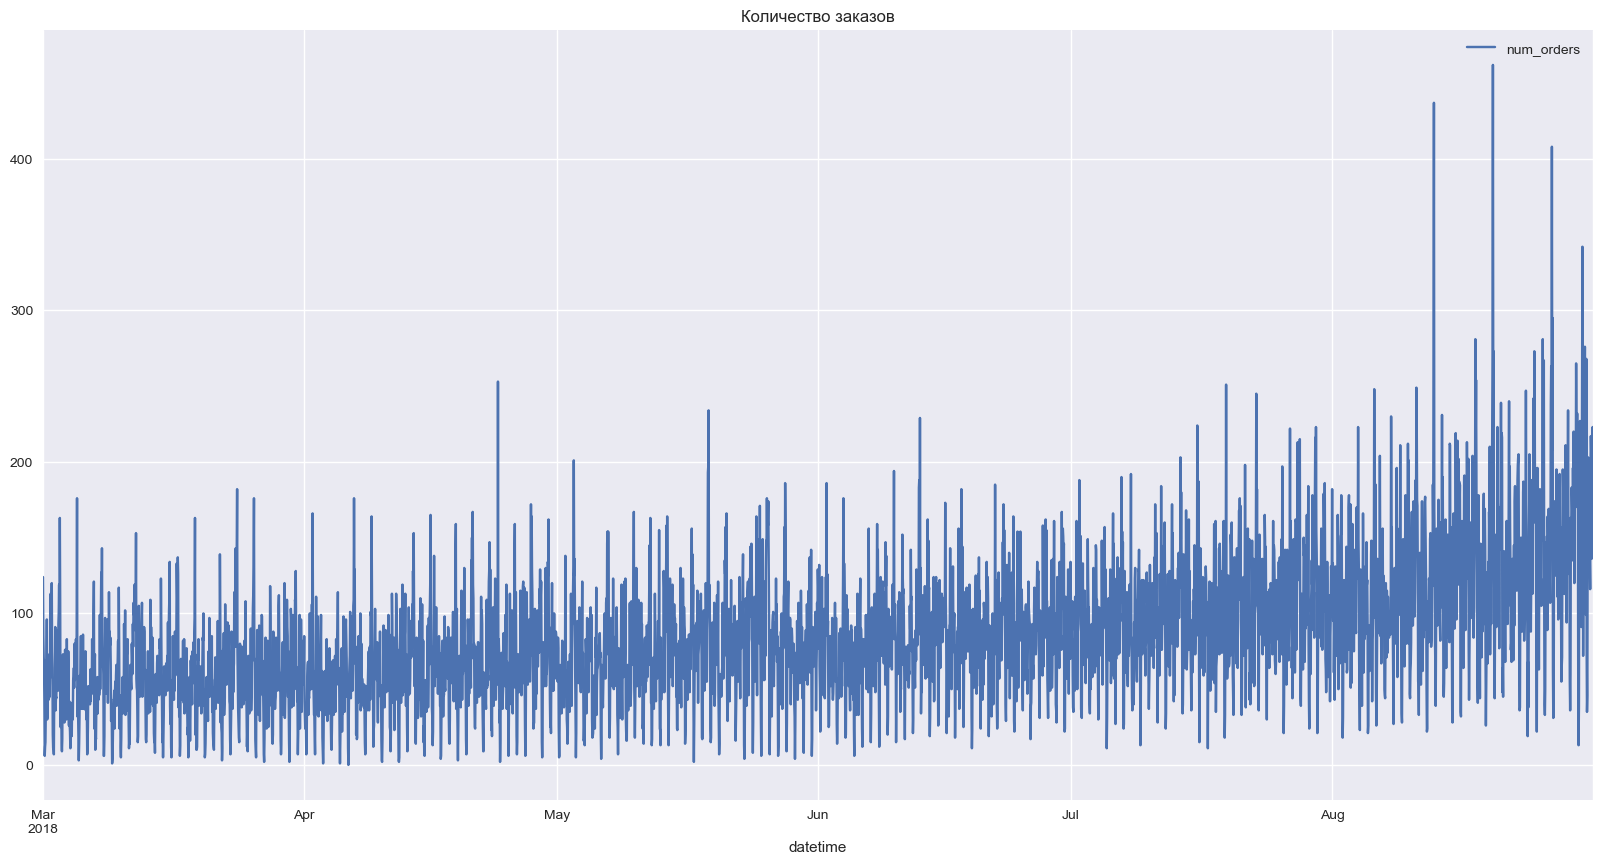

In [7]:
df.plot(figsize=(20,10), title='Количество заказов');

Можем пронаблюдать увеличение количества заказов летом. Для выявления сезонности используем библиотеку `statsmodels`

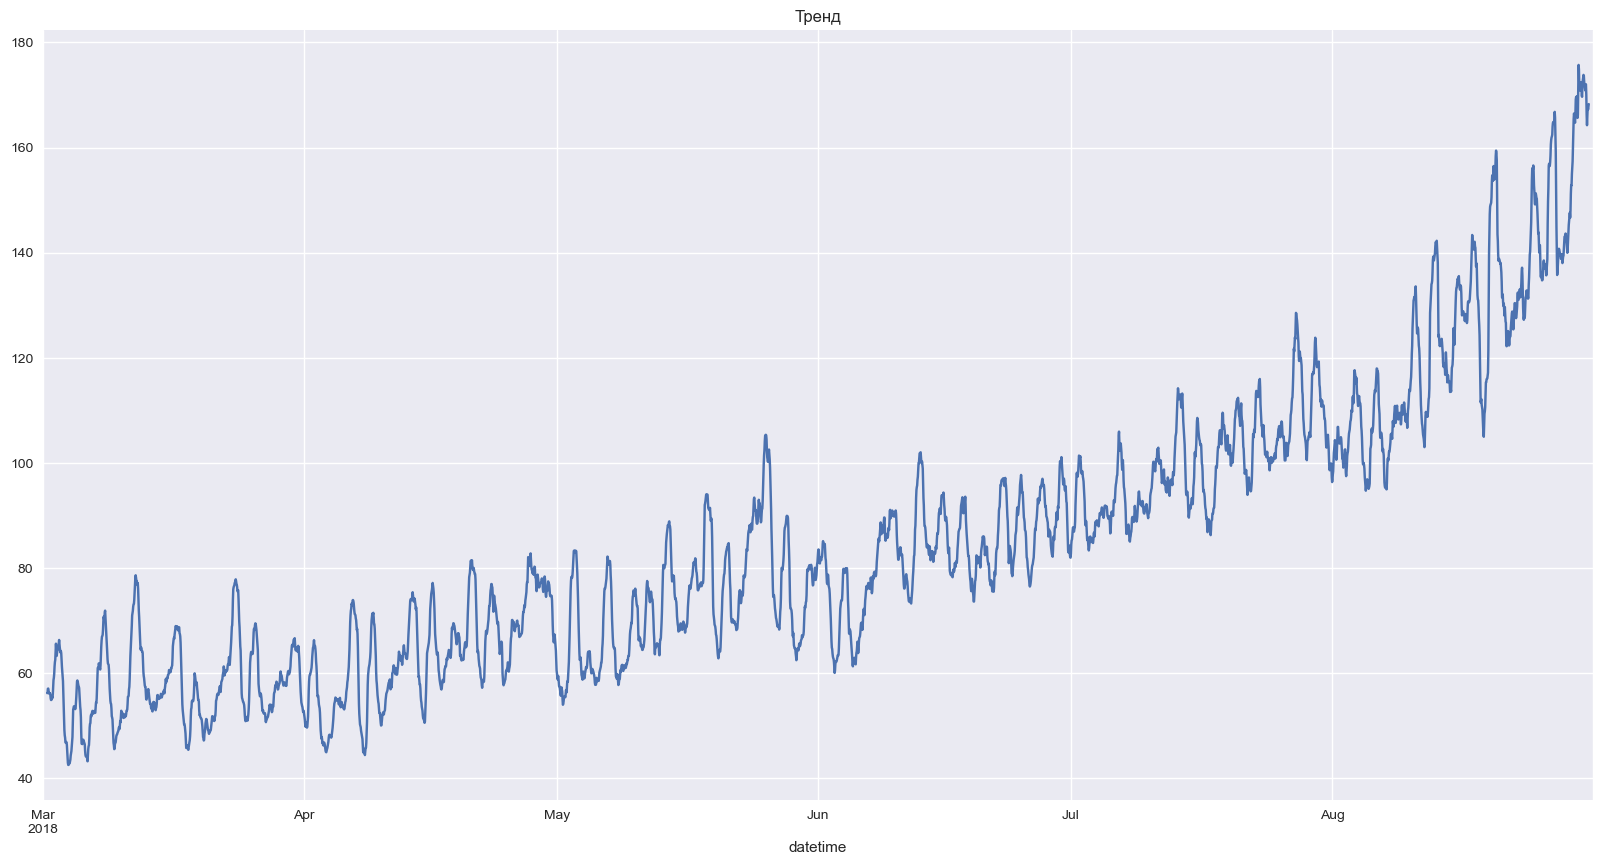

In [8]:
decomposed = seasonal_decompose(df)

decomposed.trend.plot(figsize=(20,10), title='Тренд');

Наблюдаем восходящий тренд. Для выявления сезонной составляющей мы посмотрим данные за 1 неделю

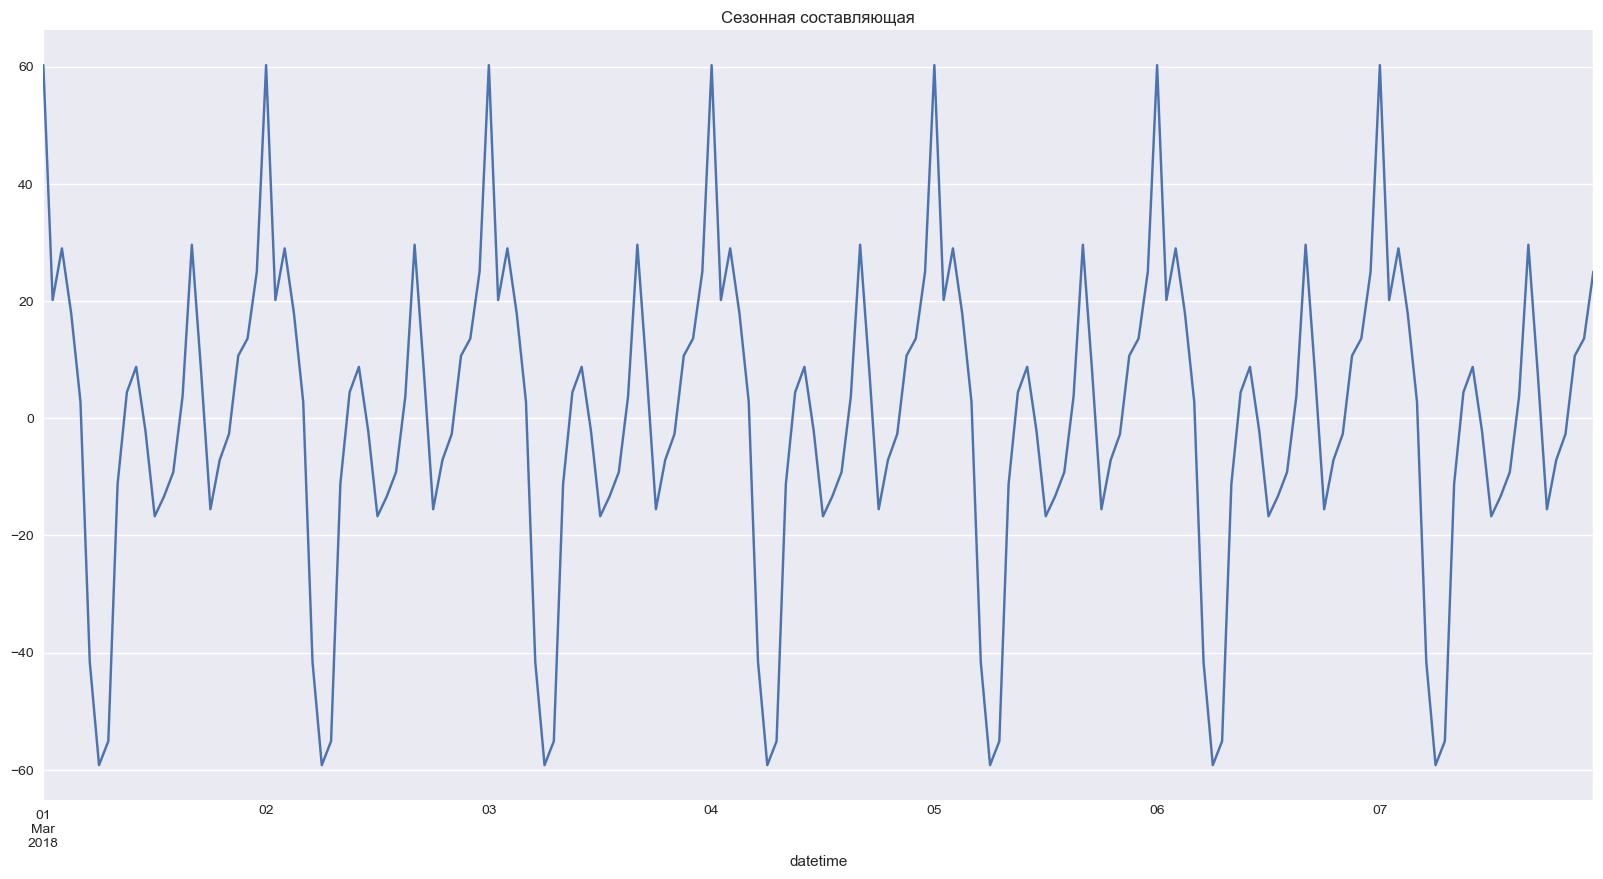

In [9]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(20,10), title='Сезонная составляющая');

Наблюдаем циличность в данных. Самый пик заказов происходит перед полуночью, утром наоборот наименьшее количество заказов

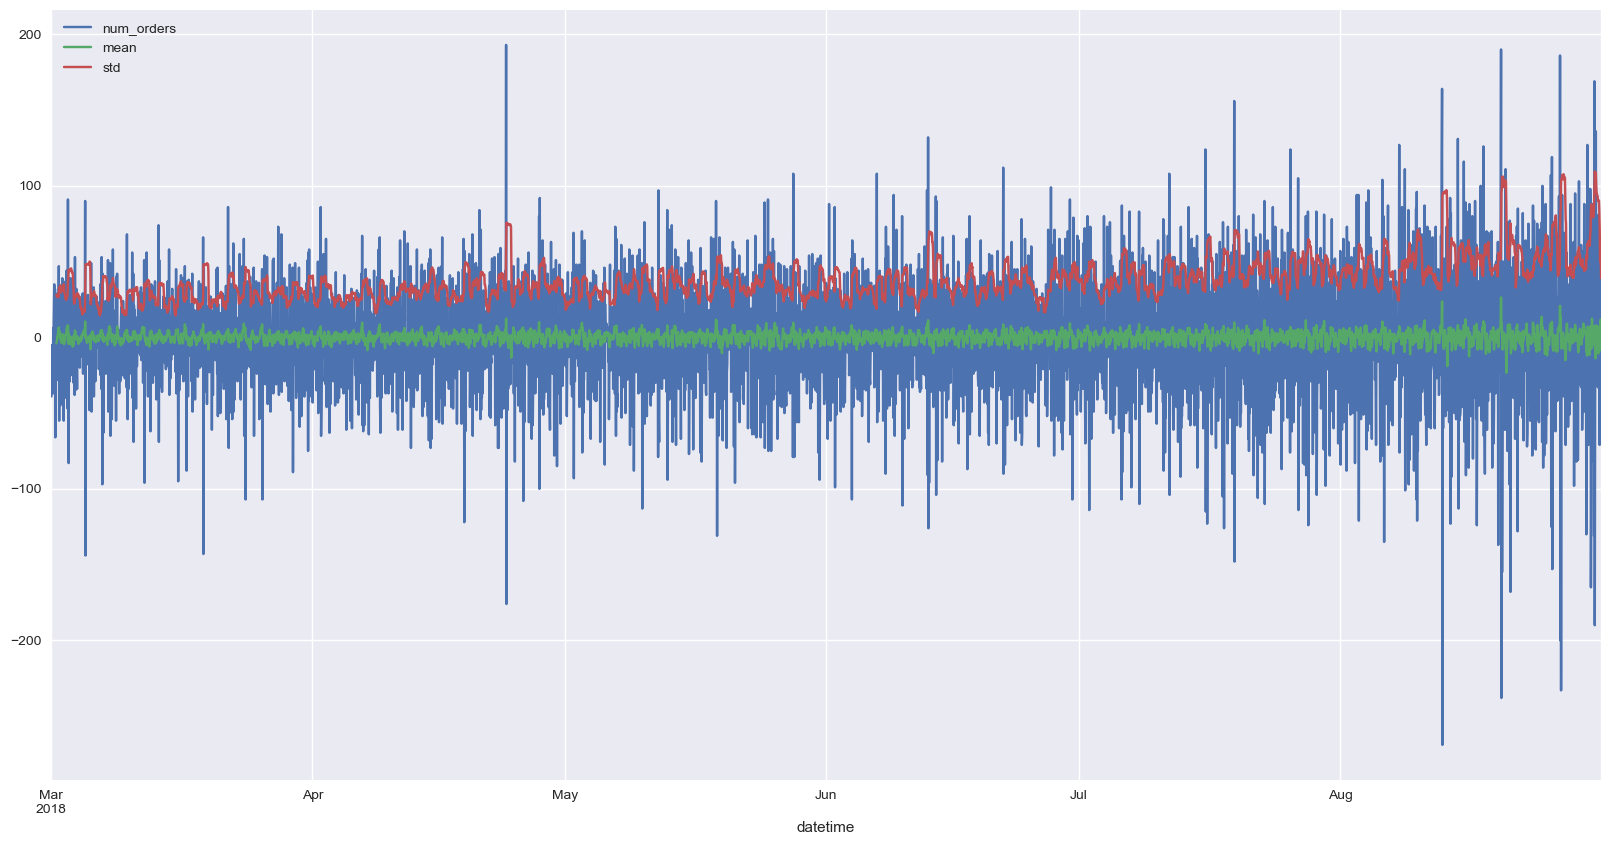

In [10]:
test = df.copy()
test = test-test.shift()
test['mean'] = test['num_orders'].rolling(15).mean()
test['std'] = test['num_orders'].rolling(15).std()
test.plot(figsize=(20,10));

Используя разность временого ряда, мы получили более стационарный вид

**Вывод**   
Имеется тренд увеличения количество заказов. Так же была обнаружена сезонная составляющая длительностью 1 сутки. Имеется пик заказов ближе к полуночи, но ближе к 6 утра имеется спад заказов такси. 

Используя разность заказов мы получили более стационарный вид, но даже на нём можно пронаблюдать как ближе к лету у нас увеличивается std

## Обучение

### Создание признаков

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    '''Добавляет столбцу календарные признаки, отстающие значения и скользящее среднее'''
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return 

In [12]:
make_features(df, 2, 24)

**Вывод**    
По скольку у нас есть сезонность длительностью 24 часа было решено создать 24 отстающих значения 

### Качество прогноза

In [13]:
# создание оценщика 
def rmse(target, predictions):
    '''Функция высчитывает RMSE'''
    return mean_squared_error(target, predictions)**0.5

scor = make_scorer(rmse, greater_is_better=False)

In [14]:
# разбиваю на тренировочную и тестовую выборку
train, test = train_test_split(df, shuffle=False, test_size=0.1)   

In [15]:
print(f'Средний объем заказов в день = {test.num_orders.mean()}')

pred_median = np.ones(test.shape) * train['num_orders'].median()
print(f'RМSE в случае предсказания тестовой выборки одни и тем же числом = {rmse(test, pred_median)}')

pred_previous = test.shift(fill_value = train.iloc[-1,0])['num_orders']
print(f'RMSE предсказания, которое основывается на предыдущем значении ряда = {rmse(test.num_orders, pred_previous)}')

Средний объем заказов в день = 139.55656108597285
RМSE в случае предсказания тестовой выборки одни и тем же числом = 77.73609334769654
RMSE предсказания, которое основывается на предыдущем значении ряда = 58.856486242815066


Среднеквадротичная ошибка нашей модели должна быть ниже 58.85

In [16]:
train.head() # посмотрим на значение train столбца

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN


In [17]:
train = train.dropna() #удаляем пропуски 

In [18]:
target_train = train['num_orders'].copy()
features_train = train.drop(columns=['num_orders']).copy()
target_test = test['num_orders'].copy()
features_test = test.drop(columns=['num_orders']).copy()

**Вывод**     
Был создан оценщик RMSE, так же разбиты данные на тренировочные и тестовые.  
При заполнении строк предыдущим значением RMSE составило 55.29    
ML обязана получить RMSE ниже 55.29

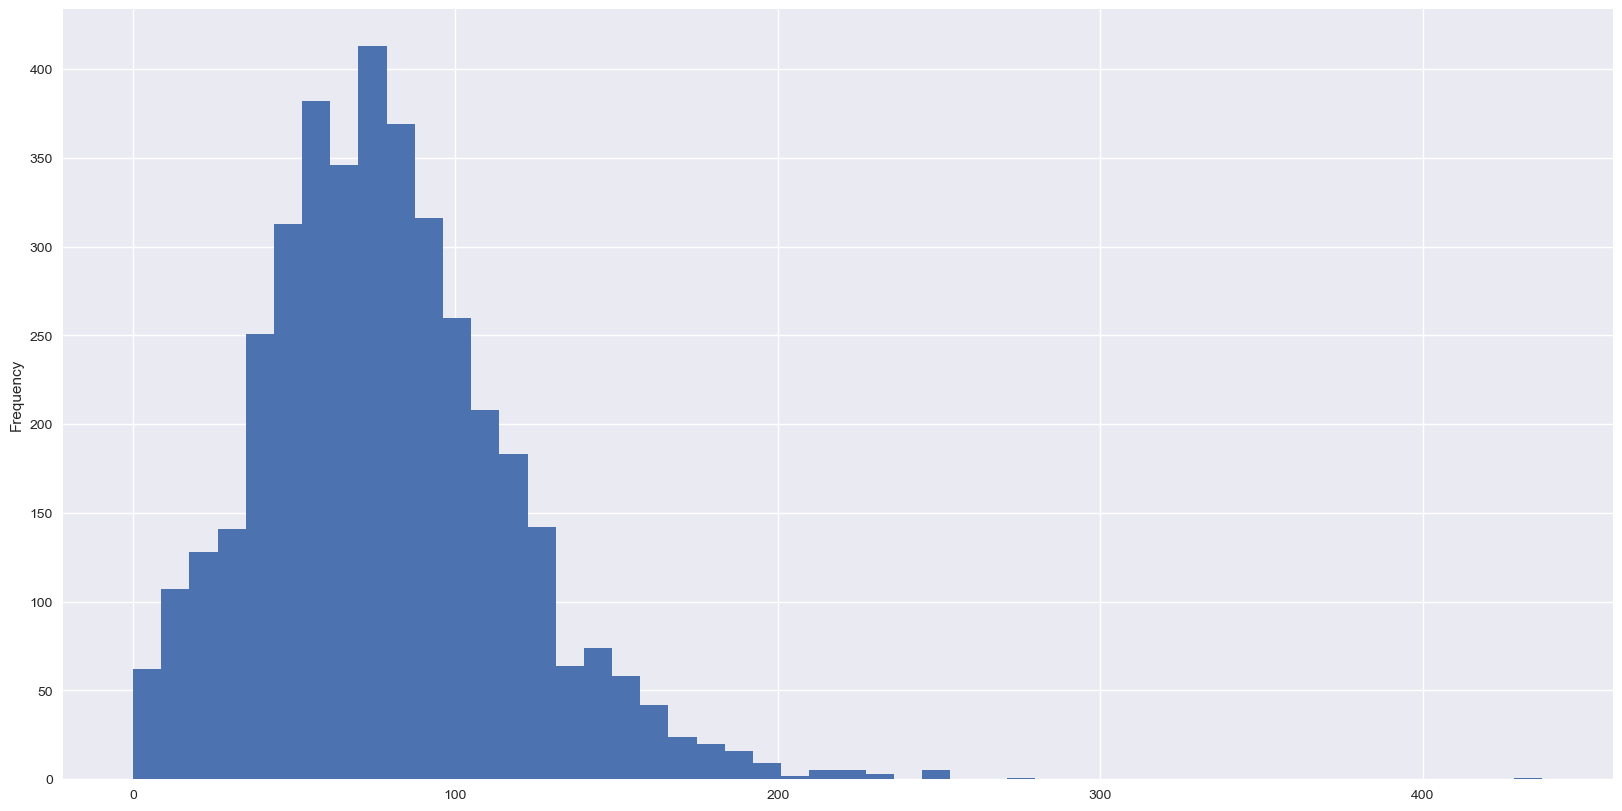

In [20]:
# посмотрим на распределение целевой переменной
target_train.plot(kind='hist',bins=50, figsize=(20,10));

## Тестирование

In [21]:
def GridTrain(model, parametrs):
    '''Функция проводит поиск наилучших гиперпараметров модели при помощи кроссвалидации, возвращает обученную модель
    с наилучшими параметрами'''
    tscv = TimeSeriesSplit(n_splits=6, test_size=60)
    grid = GridSearchCV(model, param_grid=parametrs, cv=tscv, scoring=scor, verbose=4, n_jobs=-1)
    grid.fit(features_train, target_train)
    print(f'RMSE во время кросс валидации = {-grid.best_score_}')
    print('Параметры наилучшей модели')
    print(grid.best_params_)
    return grid.best_estimator_.fit(features_train, target_train)

### Линейная модель

In [22]:
model = LinearRegression()
parametrs = {'fit_intercept':[True,False]}

model1 = GridTrain(model, parametrs)

Fitting 6 folds for each of 2 candidates, totalling 12 fits
RMSE во время кросс валидации = 41.00573050178814
Параметры наилучшей модели
{'fit_intercept': False}


### Случайный лес

In [23]:
model = RandomForestRegressor(random_state=4782)
parametrs = {'n_estimators':range(200, 351, 50), 
             'min_samples_split':[2, 3], 
             'min_samples_leaf':[1, 2]}

model2 = GridTrain(model, parametrs)

Fitting 6 folds for each of 16 candidates, totalling 96 fits
RMSE во время кросс валидации = 29.45555269597377
Параметры наилучшей модели
{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### LightGBM

In [24]:
model = LGBMRegressor(random_state=4782)
parametrs = {'n_estimators':range(300, 800, 50), 
             'boosting_type':['gbdt', 'dart', 'goss']}

model3 = GridTrain(model, parametrs)

Fitting 6 folds for each of 30 candidates, totalling 180 fits
RMSE во время кросс валидации = 28.253214294972043
Параметры наилучшей модели
{'boosting_type': 'gbdt', 'n_estimators': 300}


### Отбор наилучшей модели 

Наилучшей оценкой обладает модель LightGBM, её отбираем для обучения 

In [25]:
rmse(target_test, model3.predict(features_test))

46.65143804306479

**Вывод**     
Были отобранны 3 модели. Наилучшие параметры во время кросс валидации показала LGBMRegressor.  
Она и была отобранна для оценки на тестовой выборке.    
RMSE на тестовой выборке составила 46.6514

## Вывод
Были обработанны данные. Так же были обнаружен положительный тренд и сезонность в 24 часа.     
RMSE предсказания средним значением составила 84.3     
RMSE предсказания предыдущим значением составила 58.85      

При помощи кросс-валидации была отобрана модель LGBMRegressor с наилучшими гиперпараметрами. 
Оценка на тестовой выборке составила 42.0089
Ниже предоставленны результат модели за 2 дня. 

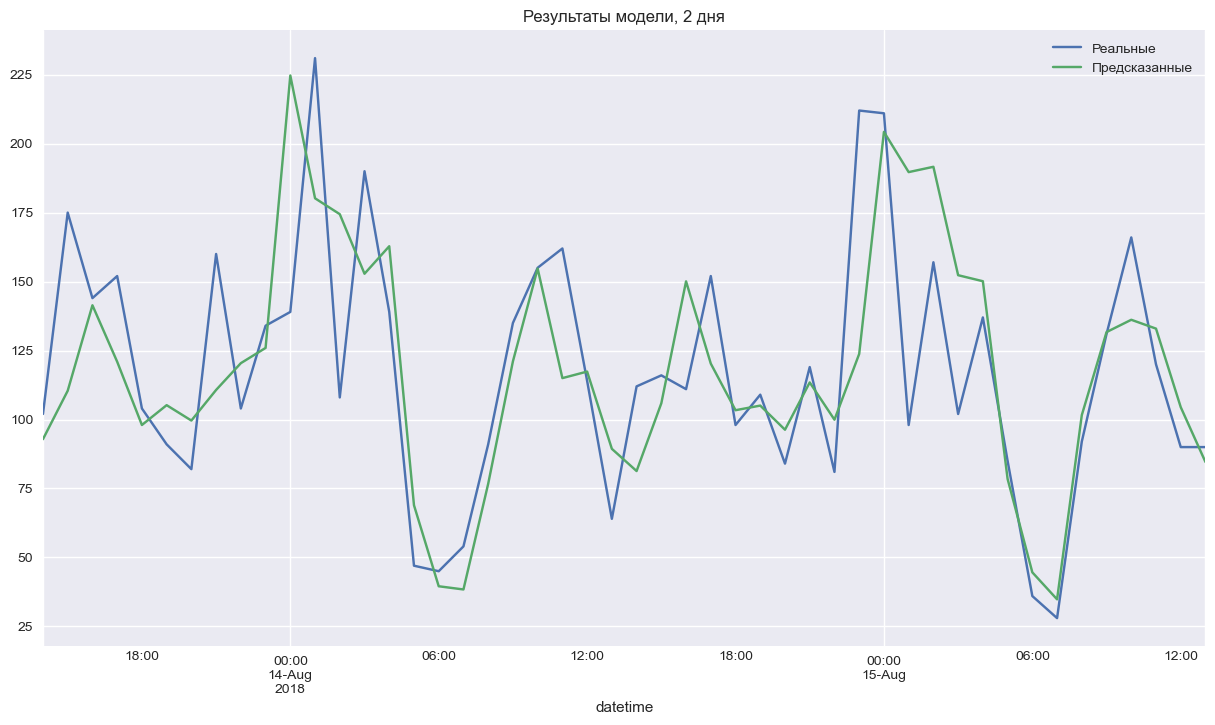

In [26]:
target_test.rename('Реальные', inplace=True)
test_predict = pd.Series(model3.predict(features_test), index=target_test.index).rename('Предсказанные', inplace=True)
result = pd.concat([target_test, test_predict], axis=1)
result.head(48).plot(figsize=(15,8), title='Результаты модели, 2 дня' );

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48